## Final Project Submission

Please fill out:
* Student name: Daniel Quillao
* Student pace: Self-paced
* Scheduled project review date/time: 4/13/21 at 2PM PST
* Instructor name: Jeff Herman
* Blog post URL: https://dquillao.github.io/mod_2_project_feature_engineering_zipcodes

# 1. Obtain Data

In [1353]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

import scipy.stats as stats

import pickle

In [1354]:
df = pd.read_csv('kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


# 2. Scrub and Clean Data

In [1355]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

## Check for erroneous values

In [1356]:
# Preview the 5 most frequent entries from each column
for col in df.columns:
    try:
        print(col, df[col].value_counts()[:5])
    except:
        print(col, df[col].value_counts())
        # If there aren't 5+ unique values for a column the first print statement
        # will throw an error for an invalid idx slice
    print('\n') # Break up the output between columns

id 795000620     3
1825069031    2
2019200220    2
7129304540    2
1781500435    2
Name: id, dtype: int64


date 6/23/2014    142
6/25/2014    131
6/26/2014    131
7/8/2014     127
4/27/2015    126
Name: date, dtype: int64


price 350000.0    172
450000.0    172
550000.0    159
500000.0    152
425000.0    150
           ... 
870515.0      1
336950.0      1
386100.0      1
176250.0      1
884744.0      1
Name: price, Length: 3622, dtype: int64


bedrooms 3    9824
4    6882
2    2760
5    1601
6     272
Name: bedrooms, dtype: int64


bathrooms 2.50    5377
1.00    3851
1.75    3048
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      71
4.75      23
5.00      21
Name: bathrooms, dtype: int64


sqft_living 1300    138
1400    135
1440    133
1660    129
1010    129
Name: sqft_living, dtype: int64


sqft_lot 5000    358
6000    290
4000    251
7200    220
7500    119
Name: sqft_lot, dtype: 

Notes: sqft_basement change to float, update '?' values

In [1357]:
# sqft_basement: check for instances of '?'
df['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
2300.0        1
792.0         1
2500.0        1
20.0          1
1275.0        1
Name: sqft_basement, Length: 304, dtype: int64

In [1358]:
# Drop rows as it only accounts for 2% of the data
df = df.drop(df[df['sqft_basement']=='?'].index)

In [1359]:
df['sqft_basement'] = pd.to_numeric(df['sqft_basement'])

## Check for nulls

In [1360]:
# Check sum of nulls
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2339
view               61
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3754
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

Note: Check waterfront, view, and yr_renovated

In [1361]:
# Get statistics
df[['waterfront', 'view', 'yr_renovated']].describe()

,waterfront,view,yr_renovated
count,18804.000000,21082.000000,17389.000000
mean,0.007552,0.233327,82.991949
std,0.086573,0.765066,398.481819
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,1.000000,4.000000,2015.000000


In [1362]:
null_list = ['waterfront', 'view', 'yr_renovated']

for feature in null_list:
    print(df[feature].value_counts())

0.0    18662
1.0      142
Name: waterfront, dtype: int64
0.0    19018
2.0      930
3.0      496
1.0      327
4.0      311
Name: view, dtype: int64
0.0       16666
2014.0       69
2003.0       31
2013.0       31
2007.0       30
          ...  
1953.0        1
1944.0        1
1934.0        1
1971.0        1
1959.0        1
Name: yr_renovated, Length: 69, dtype: int64


Notes:
- waterfront has 2339 null values
- view has 61 null values
- yr_renovated has 3754 null values
- The majority of the data is 0 for these features. Update null values to 0.

In [1363]:
# Update null values to 0
df.fillna(0, inplace = True)

In [1364]:
# Double-check for null values
df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [1365]:
# Check for duplicates
print(len(df[df.duplicated()]))

0


# 4. Explore Data

## Feature Engineering

Notes:
- yr_renovated: convert to binary {0: not renovated, 1: renovated}
- sqft_basement: convert to binary {0: no basement, 1: has basement}
- waterfront: convert to binary {0: no waterfront, 1: has waterfront}
- date and id: not useful, drop
- lat and long: should be categorical, however might be better to drop (i think zip code will be a similar/better feauture)
- convert zip code to priced tier ranks (1-10)

In [1366]:
# yr_renovated
df['yr_renovated'].value_counts()

0.0       20420
2014.0       69
2003.0       31
2013.0       31
2007.0       30
          ...  
1953.0        1
1944.0        1
1934.0        1
1971.0        1
1959.0        1
Name: yr_renovated, Length: 69, dtype: int64

In [1367]:
# Create new column renovated
df['renovated'] = df['yr_renovated'].map(lambda x: 1 if x > 0 else 0)
# Drop yr_renovated column
df = df.drop('yr_renovated', axis=1)

In [1368]:
# Check new column
df['renovated'].value_counts()

0    20420
1      723
Name: renovated, dtype: int64

In [1369]:
# sqft_basement
df['sqft_basement'].value_counts()

0.0       12826
600.0       217
500.0       209
700.0       208
800.0       201
          ...  
915.0         1
295.0         1
1281.0        1
2130.0        1
906.0         1
Name: sqft_basement, Length: 303, dtype: int64

In [1370]:
# Create new column basement
df['basement'] = df['sqft_basement'].map(lambda x: 1 if x > 0 else 0)
# Drop sqft_basement column
df = df.drop('sqft_basement', axis=1)

In [1371]:
# Check new column
df['basement'].value_counts()

0    12826
1     8317
Name: basement, dtype: int64

In [1372]:
# view
df['view'].value_counts()

0.0    19079
2.0      930
3.0      496
1.0      327
4.0      311
Name: view, dtype: int64

In [1373]:
# Update view
df['view'] = df['view'].map(lambda x: 1 if x > 0 else 0)

In [1374]:
# Check view
df['view'].value_counts()

0    19079
1     2064
Name: view, dtype: int64

In [1375]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21143 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21143 non-null  int64  
 1   date           21143 non-null  object 
 2   price          21143 non-null  float64
 3   bedrooms       21143 non-null  int64  
 4   bathrooms      21143 non-null  float64
 5   sqft_living    21143 non-null  int64  
 6   sqft_lot       21143 non-null  int64  
 7   floors         21143 non-null  float64
 8   waterfront     21143 non-null  float64
 9   view           21143 non-null  int64  
 10  condition      21143 non-null  int64  
 11  grade          21143 non-null  int64  
 12  sqft_above     21143 non-null  int64  
 13  yr_built       21143 non-null  int64  
 14  zipcode        21143 non-null  int64  
 15  lat            21143 non-null  float64
 16  long           21143 non-null  float64
 17  sqft_living15  21143 non-null  int64  
 18  sqft_l

In [1376]:
# waterfront
df['waterfront'].value_counts()

0.0    21001
1.0      142
Name: waterfront, dtype: int64

In [1377]:
# Update waterfront
df['waterfront'] = df['waterfront'].map(lambda x: 1 if x > 0 else 0)

In [1378]:
# Check waterfront
df['waterfront'].value_counts()

0    21001
1      142
Name: waterfront, dtype: int64

In [1379]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21143 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21143 non-null  int64  
 1   date           21143 non-null  object 
 2   price          21143 non-null  float64
 3   bedrooms       21143 non-null  int64  
 4   bathrooms      21143 non-null  float64
 5   sqft_living    21143 non-null  int64  
 6   sqft_lot       21143 non-null  int64  
 7   floors         21143 non-null  float64
 8   waterfront     21143 non-null  int64  
 9   view           21143 non-null  int64  
 10  condition      21143 non-null  int64  
 11  grade          21143 non-null  int64  
 12  sqft_above     21143 non-null  int64  
 13  yr_built       21143 non-null  int64  
 14  zipcode        21143 non-null  int64  
 15  lat            21143 non-null  float64
 16  long           21143 non-null  float64
 17  sqft_living15  21143 non-null  int64  
 18  sqft_l

In [1380]:
# Drop unnecessary columns
#df.drop(columns=['date', 'id', 'lat', 'long'], inplace=True) 

In [1381]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21143 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21143 non-null  int64  
 1   date           21143 non-null  object 
 2   price          21143 non-null  float64
 3   bedrooms       21143 non-null  int64  
 4   bathrooms      21143 non-null  float64
 5   sqft_living    21143 non-null  int64  
 6   sqft_lot       21143 non-null  int64  
 7   floors         21143 non-null  float64
 8   waterfront     21143 non-null  int64  
 9   view           21143 non-null  int64  
 10  condition      21143 non-null  int64  
 11  grade          21143 non-null  int64  
 12  sqft_above     21143 non-null  int64  
 13  yr_built       21143 non-null  int64  
 14  zipcode        21143 non-null  int64  
 15  lat            21143 non-null  float64
 16  long           21143 non-null  float64
 17  sqft_living15  21143 non-null  int64  
 18  sqft_l

## Tranform zipcode in price tier ranks (1-10)

In [1382]:
df.zipcode.value_counts()

98103    588
98038    574
98115    568
98052    562
98042    542
        ... 
98102    100
98010     98
98024     79
98148     55
98039     49
Name: zipcode, Length: 70, dtype: int64

In [1383]:
# Create copy
rank_df = df.copy()

In [1384]:
# Groupby zipcode and take median price
zip_med_df = rank_df.groupby(rank_df['zipcode'])['price'].median().sort_values(ascending = False)

# Reset index after groupy
zip_med_df = zip_med_df.reset_index()

# Set as string to match
zip_med_df['zipcode'] = zip_med_df['zipcode'].astype('object')

zip_med_df.head(10)

,zipcode,price
0,98039,1880000.0
1,98004,1150000.0
2,98040,994000.0
3,98112,920000.0
4,98005,762450.0
5,98006,760184.5
6,98119,750000.0
7,98075,745000.0
8,98109,736000.0
9,98102,695000.0


In [1385]:
# https://stackoverflow.com/questions/60255203/how-to-label-every-nth-row-of-a-pandas-dataframe-by-an-incremental-value
zip_med_df['rank'] = np.divmod(np.arange(len(zip_med_df)),7)[0]+1

In [1386]:
zip_med_df.head(21)

,zipcode,price,rank
0,98039,1880000.0,1
1,98004,1150000.0,1
2,98040,994000.0,1
3,98112,920000.0,1
4,98005,762450.0,1
5,98006,760184.5,1
6,98119,750000.0,1
7,98075,745000.0,2
8,98109,736000.0,2
9,98102,695000.0,2


In [1387]:
zip_med_df.groupby(['rank'])['price'].median()

rank
1     920000.0
2     689900.0
3     575000.0
4     550000.0
5     470000.0
6     425000.0
7     375250.0
8     315000.0
9     279500.0
10    260000.0
Name: price, dtype: float64

In [1388]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,renovated,basement
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,1955,98178,47.5112,-122.257,1340,5650,0,0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,1951,98125,47.7210,-122.319,1690,7639,1,1
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,1933,98028,47.7379,-122.233,2720,8062,0,0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,1965,98136,47.5208,-122.393,1360,5000,0,1
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,1987,98074,47.6168,-122.045,1800,7503,0,0


In [1389]:
zip_med_df.drop(['price'], axis = 1, inplace = True)

In [1390]:
df = pd.merge(df, zip_med_df, on='zipcode')

In [1391]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,renovated,basement,rank
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0,0,...,1180,1955,98178,47.5112,-122.257,1340,5650,0,0,9
1,4060000240,6/23/2014,205425.0,2,1.00,880,6780,1.0,0,0,...,880,1945,98178,47.5009,-122.248,1190,6780,0,0,9
2,4058801670,7/17/2014,445000.0,3,2.25,2100,8201,1.0,0,1,...,1620,1967,98178,47.5091,-122.244,2660,8712,0,1,9
3,2976800796,9/25/2014,236000.0,3,1.00,1300,5898,1.0,0,0,...,1300,1961,98178,47.5053,-122.255,1320,7619,0,0,9
4,6874200960,2/27/2015,170000.0,2,1.00,860,5265,1.0,0,0,...,860,1931,98178,47.5048,-122.272,1650,8775,0,0,9


In [1392]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21143 entries, 0 to 21142
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21143 non-null  int64  
 1   date           21143 non-null  object 
 2   price          21143 non-null  float64
 3   bedrooms       21143 non-null  int64  
 4   bathrooms      21143 non-null  float64
 5   sqft_living    21143 non-null  int64  
 6   sqft_lot       21143 non-null  int64  
 7   floors         21143 non-null  float64
 8   waterfront     21143 non-null  int64  
 9   view           21143 non-null  int64  
 10  condition      21143 non-null  int64  
 11  grade          21143 non-null  int64  
 12  sqft_above     21143 non-null  int64  
 13  yr_built       21143 non-null  int64  
 14  zipcode        21143 non-null  object 
 15  lat            21143 non-null  float64
 16  long           21143 non-null  float64
 17  sqft_living15  21143 non-null  int64  
 18  sqft_l

In [1393]:
df.sort_values('price')

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,renovated,basement,rank
16736,40000362,5/6/2014,78000.0,2,1.00,780,16344,1.0,0,0,...,780,1942,98168,47.4739,-122.280,1700,10387,0,0,10
20712,8658300340,5/23/2014,80000.0,1,0.75,430,5050,1.0,0,0,...,430,1912,98014,47.6499,-121.909,1200,7500,0,0,6
16746,3028200080,3/24/2015,81000.0,2,1.00,730,9975,1.0,0,0,...,730,1943,98168,47.4808,-122.315,860,9000,0,0,10
2393,3883800011,11/5/2014,82000.0,3,1.00,860,10426,1.0,0,0,...,860,1954,98146,47.4987,-122.341,1140,11250,0,0,8
16567,1623049041,5/8/2014,82500.0,2,1.00,520,22334,1.0,0,0,...,520,1951,98168,47.4799,-122.296,1572,10570,0,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13241,8907500070,4/13/2015,5350000.0,5,5.00,8000,23985,2.0,0,1,...,6720,2009,98004,47.6232,-122.220,4600,21750,0,1,1
21099,2470100110,8/4/2014,5570000.0,5,5.75,9200,35069,2.0,0,0,...,6200,2001,98039,47.6289,-122.233,3560,24345,0,1,1
21106,9208900037,9/19/2014,6890000.0,6,7.75,9890,31374,2.0,0,1,...,8860,2001,98039,47.6305,-122.240,4540,42730,0,1,1
13284,9808700762,6/11/2014,7060000.0,5,4.50,10040,37325,2.0,1,1,...,7680,1940,98004,47.6500,-122.214,3930,25449,1,1,1


## Check for outliers

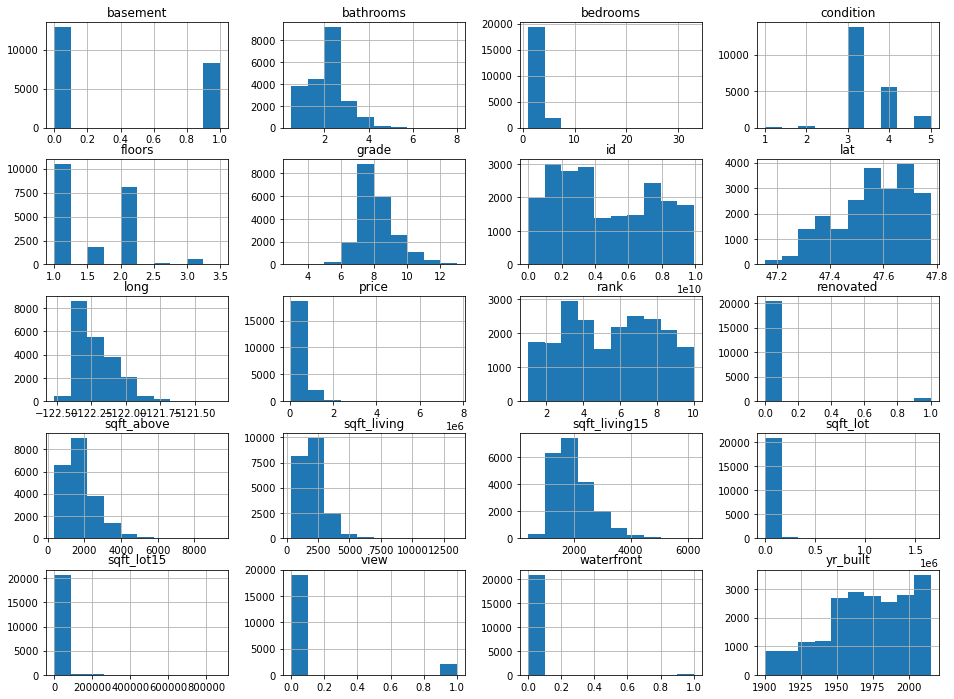

In [1394]:
df.hist(figsize=(16, 12));

In [1395]:
# Removes feats with z-score above 3 for specific columns
# Reference https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame

outlier_feats = ['price', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15', 'sqft_above', 'bathrooms', 'bedrooms', 'floors']

for feat in outlier_feats:
    df = df[np.abs(df[feat]-df[feat].mean()) <= (3*df[feat].std())]

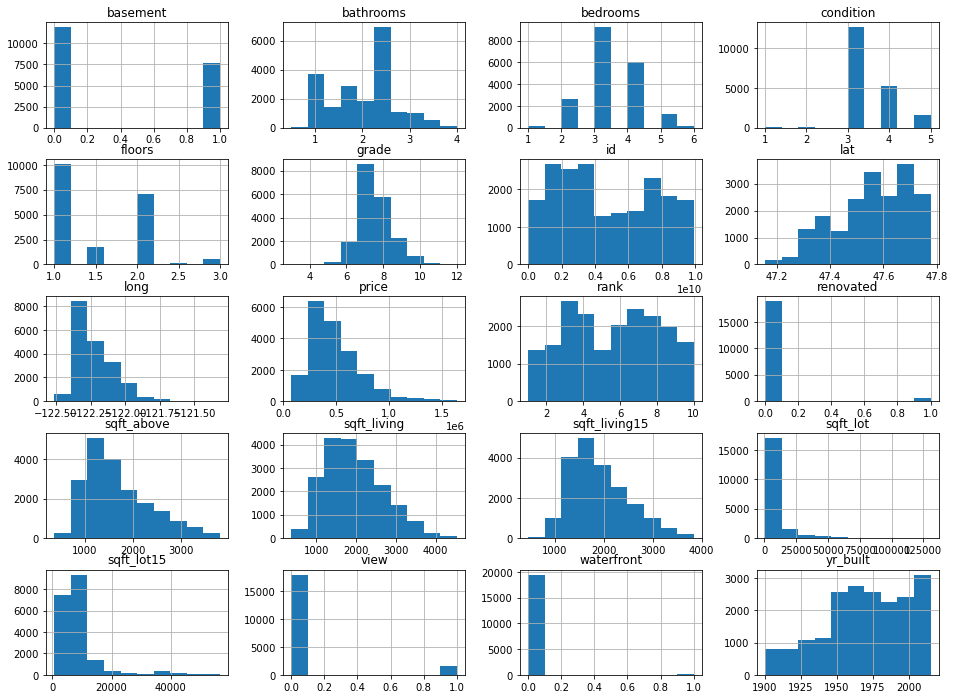

In [1396]:
df.hist(figsize=(16,12));

In [1397]:
df.floors.value_counts()

1.0    10054
2.0     7061
1.5     1752
3.0      564
2.5      114
Name: floors, dtype: int64

In [1398]:
df.bedrooms.value_counts()

3    9220
4    6058
2    2614
5    1274
6     196
1     183
Name: bedrooms, dtype: int64

In [1399]:
df.bathrooms.value_counts()

2.50    4976
1.00    3694
1.75    2900
2.25    1930
2.00    1816
1.50    1394
2.75    1069
3.00     646
3.50     512
3.25     400
3.75      75
0.75      67
4.00      54
1.25       9
0.50       3
Name: bathrooms, dtype: int64

## Visualize zip codes

In [1400]:
# find map center using lat and long
def get_center_latlong(df):
    # get the center of my map for plotting
    centerlat = (df['lat'].max() + df['lat'].min()) / 2
    centerlong = (df['long'].max() + df['long'].min()) / 2
    return centerlat, centerlong

In [1401]:
import folium

# grab the center of our map using function
center = get_center_latlong(df)

# create a new map object
m = folium.Map(location=center, zoom_start=10)

# save our map to an interactive html file
m.save('circle_map.html')

In [1402]:
import branca.colormap as cm

# create a LinearColorMap and assign colors, vmin, and vmax
# the colormap will show green for $100,000 homes all the way up to red for $1,500,000 homes
colormap = cm.LinearColormap(colors=['green', 'yellow', 'red'], vmin=100000, vmax=1500000)

# create our map again.  This time I am using a different tileset for a new look
m = folium.Map(location=center, zoom_start=10, tiles='Stamen Toner')

# Same as before... go through each home in set, make circle, and add to map.
# This time we add a color using price and the colormap object
for i in range(len(df)):
    folium.Circle(
        location=[df.iloc[i]['lat'], df.iloc[i]['long']],
        radius=10,
        fill=True,
        color=colormap(df.iloc[i]['price']),
        fill_opacity=0.2
    ).add_to(m)

# the following line adds the scale directly to our map
m.add_child(colormap)

# Save map 
m.save('price_colormap.html')

In [1403]:
price_max = df.price.max()
price_max

1640000.0

In [1404]:
price_min = df.price.min()
price_min

78000.0

## Check for linearity: Joint Plots

/Users/daniel/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
/Users/daniel/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
/Users/daniel/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
/Users/daniel/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
/Users/daniel/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warning

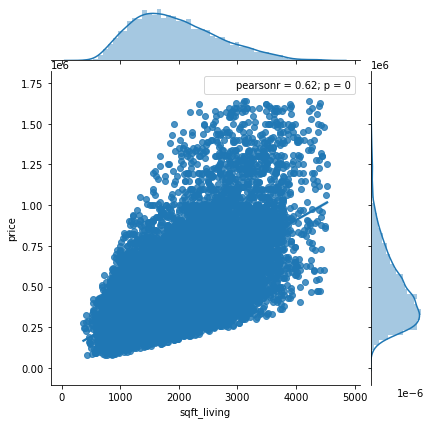

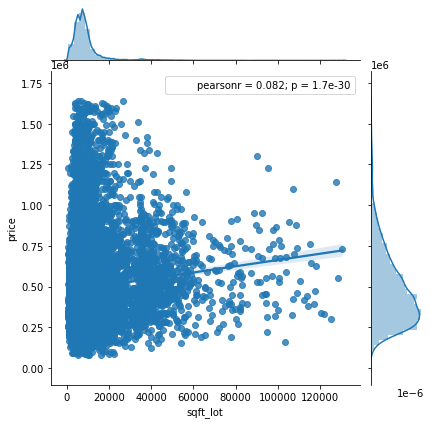

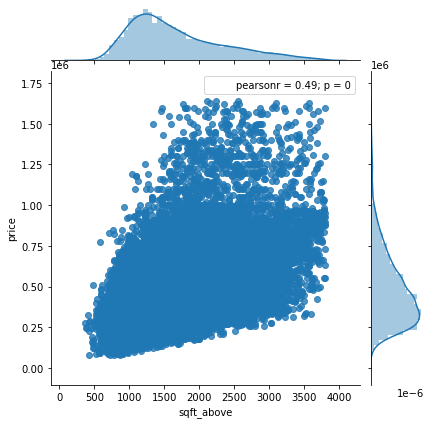

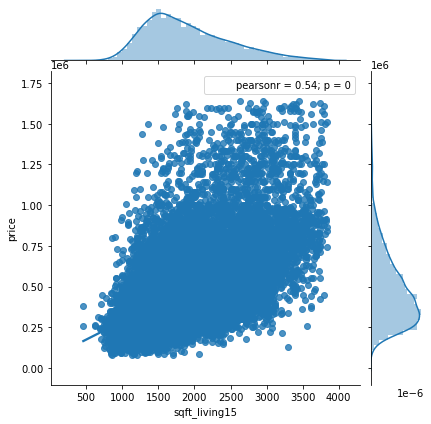

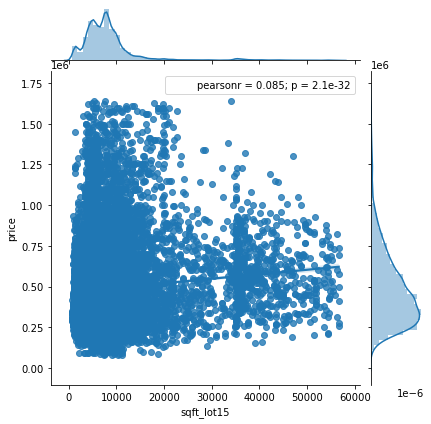

In [1405]:
# Plot joint plots
joint_feats = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_living15', 'sqft_lot15']

for feat in joint_feats:
    j = sns.jointplot(x = df[feat], y = df['price'], kind = 'reg')
    j.annotate(stats.pearsonr)

Note: sqft_living, sqft_above, and sqft_living15 have a moderate linear relationship with price

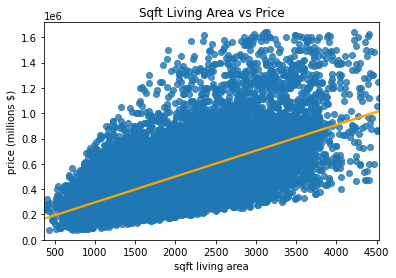

In [1406]:
x = df['sqft_living']
y = df['price']

ax = sns.regplot(x, y, line_kws={"color": "orange"})
plt.xlabel('sqft living area')
plt.ylabel('price (millions $)')
plt.title('Sqft Living Area vs Price')
plt.show()

## Check for linearity: Box Plots

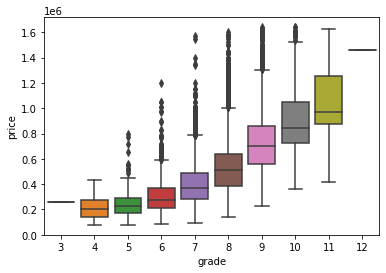

In [1407]:
sns.boxplot(x = df['grade'], y = df['price'])

Note: Strong relationship with price

In [1408]:
median_grade = df.groupby('grade')['price'].median().reset_index()
median_grade

,grade,price
0,3,262000.0
1,4,200000.0
2,5,225000.0
3,6,275000.0
4,7,373000.0
5,8,509975.0
6,9,700500.0
7,10,845800.0
8,11,973900.0
9,12,1460000.0


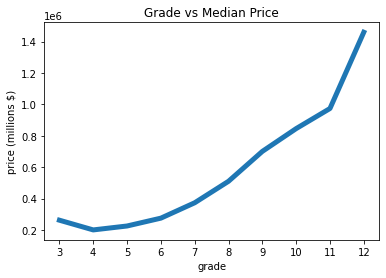

In [1409]:
fig = sns.lineplot(x = 'grade', y = 'price', data = median_grade, lw=5)
plt.xlabel('grade')
plt.ylabel('price (millions $)')
plt.xticks(range(3,13))
plt.title('Grade vs Median Price')
plt.show()

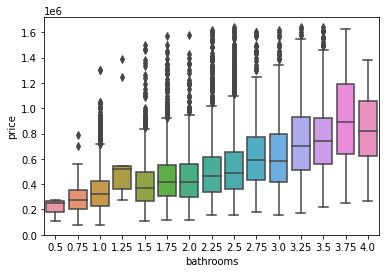

In [1410]:
sns.boxplot(x = df['bathrooms'], y = df['price'])

Note: Strong relationship with price

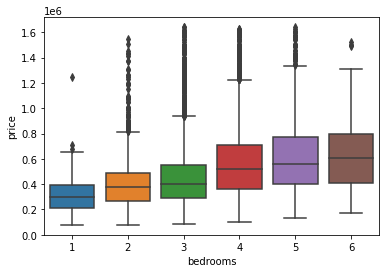

In [1411]:
sns.boxplot(x = df['bedrooms'], y = df['price'])

Note: Moderate relationship with price

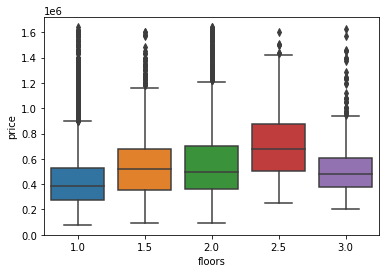

In [1412]:
sns.boxplot(x = df['floors'], y = df['price'])

Note: Not much of a relationship with price

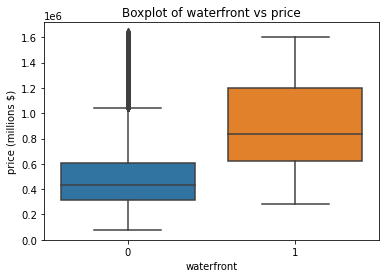

In [1413]:
sns.boxplot(x = df['waterfront'], y = df['price'])
plt.title('Boxplot of waterfront vs price');
plt.ylabel('price (millions $)');

In [1414]:
median_waterfront = df.groupby('waterfront')['price'].median().reset_index()
median_waterfront

,waterfront,price
0,0,435000.0
1,1,835000.0


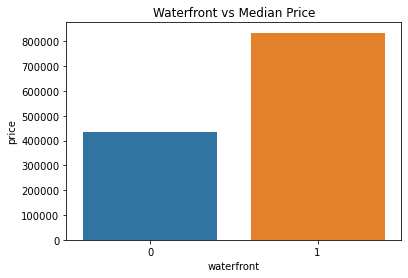

In [1415]:
fig = sns.barplot(x = 'waterfront', y = 'price', data = median_waterfront)
plt.xlabel('waterfront')
plt.ylabel('price')
plt.title('Waterfront vs Median Price')
plt.show()

Note: Strong relationship with price

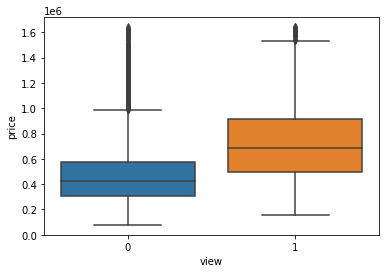

In [1416]:
sns.boxplot(x = df['view'], y = df['price'])

Note: Moderate relationship with price

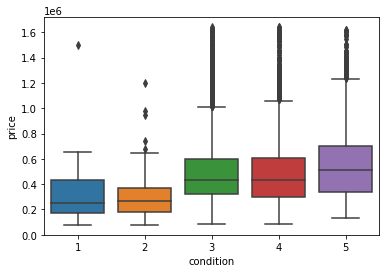

In [1417]:
sns.boxplot(x = df['condition'], y = df['price'])

Note: Not much of a relationship with price. Looks like there's an outlier as well in Condition 1.

In [1418]:
# con_out_df = df[['condition', 'price']]

In [1419]:
# con_1_df = con_out_df[con_out_df['condition'] == 1]
# con_1_df.describe()

In [1420]:
# row_to_drop = con_out_df[(con_out_df['condition'] == 1) & (con_out_df['price'] >= 1500000)]

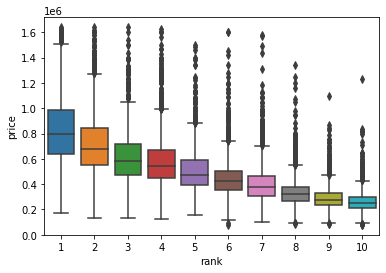

In [1421]:
sns.boxplot(x = df['rank'], y = df['price'])

Note: Strong relationship with price

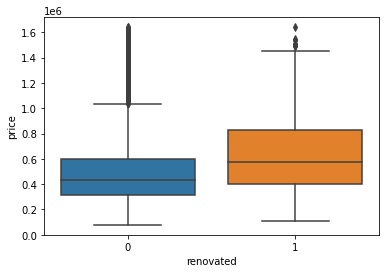

In [1422]:
sns.boxplot(x = df['renovated'], y = df['price'])

Note: Not much of a relationship with price

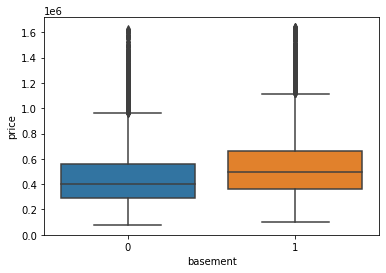

In [1423]:
sns.boxplot(x = df['basement'], y = df['price'])

Note: Not much of a relationship with price

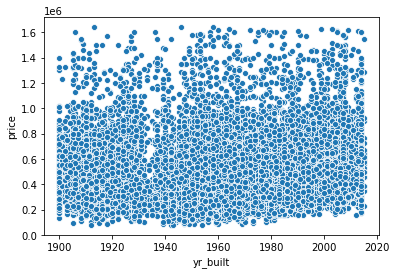

In [1424]:
sns.scatterplot(x = df['yr_built'], y = df['price'])

Note: No relationship with price

In [1425]:
# Drop unnecessary columns
df.drop(columns=['date', 'id', 'lat', 'long'], inplace=True) 

## Normalize Continuous Features

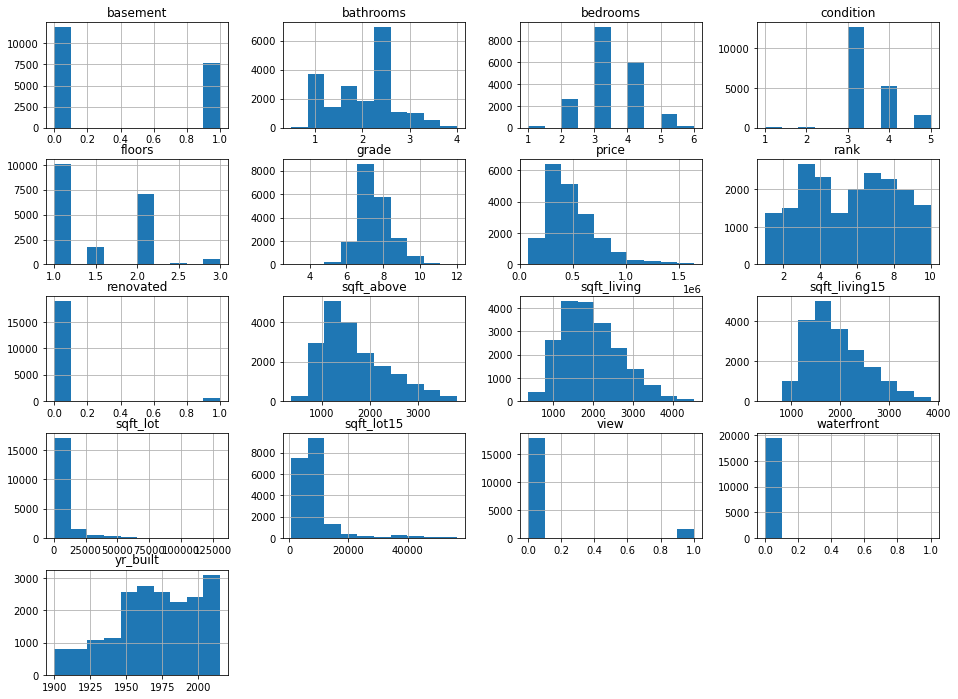

In [1426]:
df.hist(figsize = (16,12));

In [1427]:
# Log transform to reduce skewness
# Remember that you can't take the logarithm of zero nor a negative number
#log_feats = ['sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15', 'sqft_above', 'bedrooms', 'bathrooms', 'floors']
#for var in log_feats:
#    df[var]= np.log(df[var])

In [1428]:
#df.hist(figsize = (16,12));

In [1429]:
# Standardization (z-score normalization)
# x' will have mean  𝜇=0  and  𝜎=1 
# Note that standardization does not make data more normal, it will just change the mean and the standard error

#continuous_feats = ['sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15', 'sqft_above', 'bedrooms', 'bathrooms', 'floors']

#for var in continuous_feats:
#    df[var] = (df[var] - df[var].mean()) / df[var].std()

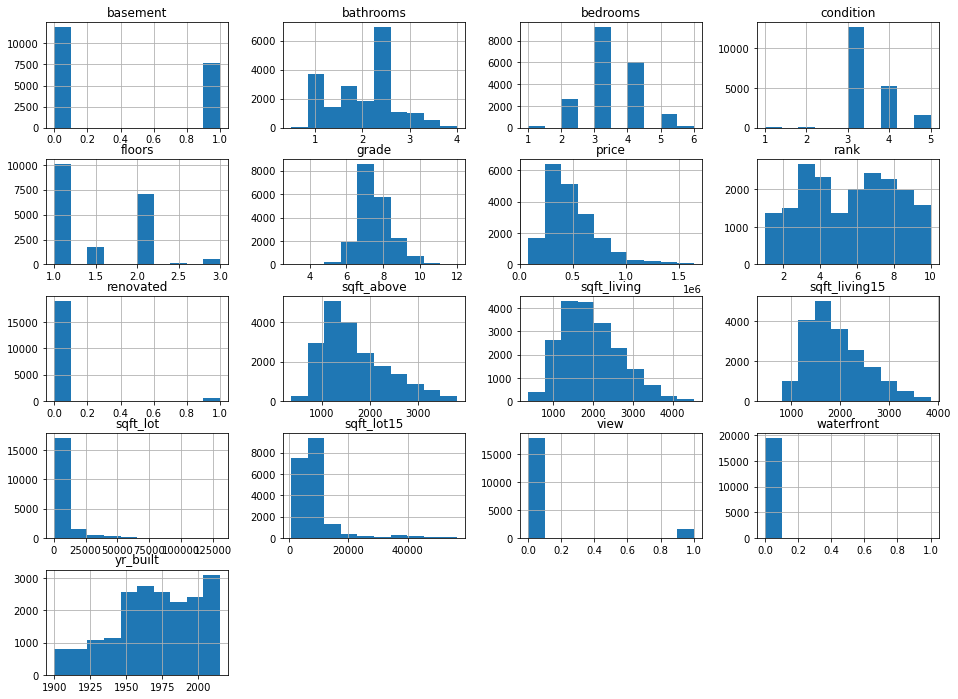

In [1430]:
df.hist(figsize = (16, 12));

In [1431]:
for i in range(80,100):
    q = i/100
    print("{} percentile: {}".format(q, df.price.quantile(q=q)))

0.8 percentile: 657500.0
0.81 percentile: 670000.0
0.82 percentile: 680000.0
0.83 percentile: 695000.0
0.84 percentile: 705629.5999999997
0.85 percentile: 720000.0
0.86 percentile: 735000.0
0.87 percentile: 750000.0
0.88 percentile: 765000.0
0.89 percentile: 782000.0
0.9 percentile: 800000.0
0.91 percentile: 825000.0
0.92 percentile: 849000.0
0.93 percentile: 872730.0000000005
0.94 percentile: 900000.0
0.95 percentile: 940000.0
0.96 percentile: 990000.0
0.97 percentile: 1080000.0
0.98 percentile: 1200000.0
0.99 percentile: 1340000.0


In [1432]:
orig_tot = len(df)
df = df[df.price < 1000000] # Subsetting to remove extreme outliers
print('Percent removed:', (orig_tot -len(df))/orig_tot)

Percent removed: 0.03821949347659248


In [1433]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18798 entries, 0 to 21112
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          18798 non-null  float64
 1   bedrooms       18798 non-null  int64  
 2   bathrooms      18798 non-null  float64
 3   sqft_living    18798 non-null  int64  
 4   sqft_lot       18798 non-null  int64  
 5   floors         18798 non-null  float64
 6   waterfront     18798 non-null  int64  
 7   view           18798 non-null  int64  
 8   condition      18798 non-null  int64  
 9   grade          18798 non-null  int64  
 10  sqft_above     18798 non-null  int64  
 11  yr_built       18798 non-null  int64  
 12  zipcode        18798 non-null  object 
 13  sqft_living15  18798 non-null  int64  
 14  sqft_lot15     18798 non-null  int64  
 15  renovated      18798 non-null  int64  
 16  basement       18798 non-null  int64  
 17  rank           18798 non-null  int64  
dtypes: flo

## Check for multicollinearity

In [1434]:
corr = df.corr()
corr

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,sqft_living15,sqft_lot15,renovated,basement,rank
price,1.000000,0.279467,0.410215,0.580544,0.086616,0.250227,0.046463,0.218005,0.048638,0.594163,0.477659,0.029158,0.526771,0.083053,0.080602,0.174115,-0.704757
bedrooms,0.279467,1.000000,0.483464,0.612519,0.108552,0.146107,-0.025568,0.037202,0.027982,0.324093,0.476441,0.172741,0.391504,0.120166,-0.004825,0.150931,-0.014288
bathrooms,0.410215,0.483464,1.000000,0.693048,0.041958,0.504472,-0.015814,0.073705,-0.135239,0.597753,0.609068,0.560522,0.515247,0.051138,0.014202,0.139582,-0.121811
sqft_living,0.580544,0.612519,0.693048,1.000000,0.219303,0.324108,-0.002160,0.151396,-0.061736,0.676332,0.830843,0.347581,0.728651,0.238610,0.016408,0.192701,-0.152303
sqft_lot,0.086616,0.108552,0.041958,0.219303,1.000000,-0.119006,0.047223,0.052590,0.043810,0.119769,0.199361,0.016218,0.261692,0.807988,0.012712,-0.023646,0.022437
floors,0.250227,0.146107,0.504472,0.324108,-0.119006,1.000000,-0.006627,-0.032900,-0.278485,0.453616,0.533687,0.515854,0.256265,-0.126726,-0.006117,-0.290845,-0.139383
waterfront,0.046463,-0.025568,-0.015814,-0.002160,0.047223,-0.006627,1.000000,0.167629,0.005392,-0.016958,-0.010024,-0.033980,0.008705,0.061097,0.047582,0.010054,0.025831
view,0.218005,0.037202,0.073705,0.151396,0.052590,-0.032900,0.167629,1.000000,0.035120,0.110198,0.041109,-0.082782,0.175405,0.042640,0.043759,0.156945,-0.017562
condition,0.048638,0.027982,-0.135239,-0.061736,0.043810,-0.278485,0.005392,0.035120,1.000000,-0.169380,-0.175320,-0.349441,-0.114173,0.059979,-0.054489,0.126725,-0.020458
grade,0.594163,0.324093,0.597753,0.676332,0.119769,0.453616,-0.016958,0.110198,-0.169380,1.000000,0.682594,0.493692,0.648277,0.151700,-0.016317,0.007846,-0.286218


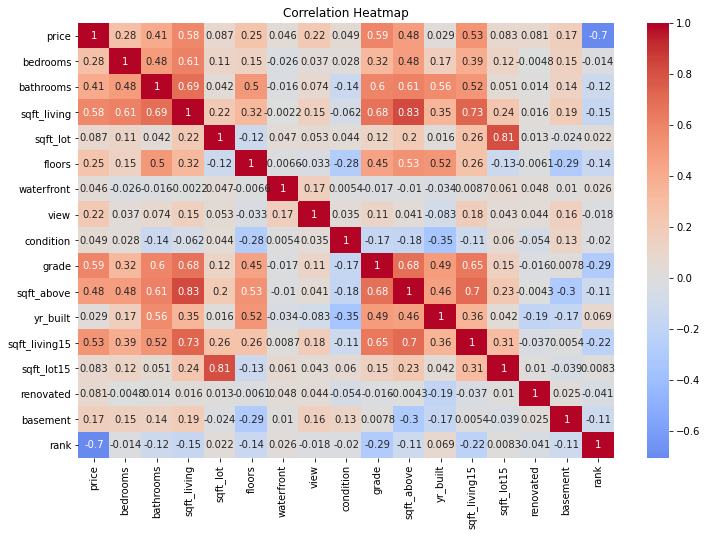

In [1435]:
# Plot heatmap
plt.figure(figsize = (12,8))
sns.heatmap(corr, center = 0, annot = True, cmap = 'coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [1436]:
corr

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,sqft_living15,sqft_lot15,renovated,basement,rank
price,1.000000,0.279467,0.410215,0.580544,0.086616,0.250227,0.046463,0.218005,0.048638,0.594163,0.477659,0.029158,0.526771,0.083053,0.080602,0.174115,-0.704757
bedrooms,0.279467,1.000000,0.483464,0.612519,0.108552,0.146107,-0.025568,0.037202,0.027982,0.324093,0.476441,0.172741,0.391504,0.120166,-0.004825,0.150931,-0.014288
bathrooms,0.410215,0.483464,1.000000,0.693048,0.041958,0.504472,-0.015814,0.073705,-0.135239,0.597753,0.609068,0.560522,0.515247,0.051138,0.014202,0.139582,-0.121811
sqft_living,0.580544,0.612519,0.693048,1.000000,0.219303,0.324108,-0.002160,0.151396,-0.061736,0.676332,0.830843,0.347581,0.728651,0.238610,0.016408,0.192701,-0.152303
sqft_lot,0.086616,0.108552,0.041958,0.219303,1.000000,-0.119006,0.047223,0.052590,0.043810,0.119769,0.199361,0.016218,0.261692,0.807988,0.012712,-0.023646,0.022437
floors,0.250227,0.146107,0.504472,0.324108,-0.119006,1.000000,-0.006627,-0.032900,-0.278485,0.453616,0.533687,0.515854,0.256265,-0.126726,-0.006117,-0.290845,-0.139383
waterfront,0.046463,-0.025568,-0.015814,-0.002160,0.047223,-0.006627,1.000000,0.167629,0.005392,-0.016958,-0.010024,-0.033980,0.008705,0.061097,0.047582,0.010054,0.025831
view,0.218005,0.037202,0.073705,0.151396,0.052590,-0.032900,0.167629,1.000000,0.035120,0.110198,0.041109,-0.082782,0.175405,0.042640,0.043759,0.156945,-0.017562
condition,0.048638,0.027982,-0.135239,-0.061736,0.043810,-0.278485,0.005392,0.035120,1.000000,-0.169380,-0.175320,-0.349441,-0.114173,0.059979,-0.054489,0.126725,-0.020458
grade,0.594163,0.324093,0.597753,0.676332,0.119769,0.453616,-0.016958,0.110198,-0.169380,1.000000,0.682594,0.493692,0.648277,0.151700,-0.016317,0.007846,-0.286218


In [1437]:
# save absolute value of correlation matrix as a data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking

df_abs = corr.abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
df_abs['pairs'] = list(zip(df_abs.level_0, df_abs.level_1))

# set index to pairs
df_abs.set_index(['pairs'], inplace = True)

#d rop level columns
df_abs.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df_abs.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
df_abs.drop_duplicates(inplace=True)

In [1438]:
abs(df.corr()) > 0.75

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,sqft_living15,sqft_lot15,renovated,basement,rank
price,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False
sqft_lot,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False
floors,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
view,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
grade,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False


In [1439]:
df_abs[(df_abs.cc>.75) & (df_abs.cc <1)]

,cc
pairs,
"(sqft_living, sqft_above)",0.830843
"(sqft_lot15, sqft_lot)",0.807988


In [1440]:
df.drop(columns=['sqft_above', 'sqft_living15', 'sqft_lot15', 'zipcode'], inplace=True) 

In [1441]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'yr_built', 'renovated',
       'basement', 'rank'],
      dtype='object')

In [1442]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18798 entries, 0 to 21112
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        18798 non-null  float64
 1   bedrooms     18798 non-null  int64  
 2   bathrooms    18798 non-null  float64
 3   sqft_living  18798 non-null  int64  
 4   sqft_lot     18798 non-null  int64  
 5   floors       18798 non-null  float64
 6   waterfront   18798 non-null  int64  
 7   view         18798 non-null  int64  
 8   condition    18798 non-null  int64  
 9   grade        18798 non-null  int64  
 10  yr_built     18798 non-null  int64  
 11  renovated    18798 non-null  int64  
 12  basement     18798 non-null  int64  
 13  rank         18798 non-null  int64  
dtypes: float64(3), int64(11)
memory usage: 2.2 MB


## One-hot encode Categorical Features

In [1443]:
categorical_feats = ['view', 'basement', 'condition', 'grade', 'renovated', 'waterfront', 'yr_built', 'rank']

# Convert to str
for col in categorical_feats:
    df[col] = df[col].astype('str')   

In [1444]:
df = pd.get_dummies(df, drop_first = True)

In [1445]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront_1,view_1,condition_2,condition_3,...,basement_1,rank_10,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9
0,221900.0,3,1.00,1180,5650,1.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,205425.0,2,1.00,880,6780,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,445000.0,3,2.25,2100,8201,1.0,0,1,0,1,...,1,0,0,0,0,0,0,0,0,1
3,236000.0,3,1.00,1300,5898,1.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,170000.0,2,1.00,860,5265,1.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


Note: This is a lot of columns.

# 4. Model Data

## Model 1: All available features

Perform a train-test split and create an initial regression model to model the price using ALL available features

Note: In order to write the model you'll have to do some tedious manipulation of your column names. Statsmodels will not allow you to have spaces, apostrophe or arithmetic symbols (+) in your column names. Preview them and refine them as you go.
If you receive an error such as "PatsyError: error tokenizing input (maybe an unclosed string?)", then you need to further preprocess your column names.

In [1446]:
subs = [(' ', '_'),('.','_'),("'",""),('™', ''), ('®',''),
        ('+','plus'), ('½','half'), ('-','_')
       ]
def col_formatting(col):
    for old, new in subs:
        col = col.replace(old,new)
    return col

In [1447]:
df.columns = [col_formatting(col) for col in df.columns]

In [1448]:
list(df.columns)

['price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront_1',
 'view_1',
 'condition_2',
 'condition_3',
 'condition_4',
 'condition_5',
 'grade_11',
 'grade_3',
 'grade_4',
 'grade_5',
 'grade_6',
 'grade_7',
 'grade_8',
 'grade_9',
 'yr_built_1901',
 'yr_built_1902',
 'yr_built_1903',
 'yr_built_1904',
 'yr_built_1905',
 'yr_built_1906',
 'yr_built_1907',
 'yr_built_1908',
 'yr_built_1909',
 'yr_built_1910',
 'yr_built_1911',
 'yr_built_1912',
 'yr_built_1913',
 'yr_built_1914',
 'yr_built_1915',
 'yr_built_1916',
 'yr_built_1917',
 'yr_built_1918',
 'yr_built_1919',
 'yr_built_1920',
 'yr_built_1921',
 'yr_built_1922',
 'yr_built_1923',
 'yr_built_1924',
 'yr_built_1925',
 'yr_built_1926',
 'yr_built_1927',
 'yr_built_1928',
 'yr_built_1929',
 'yr_built_1930',
 'yr_built_1931',
 'yr_built_1932',
 'yr_built_1933',
 'yr_built_1934',
 'yr_built_1935',
 'yr_built_1936',
 'yr_built_1937',
 'yr_built_1938',
 'yr_built_1939',
 'yr_built_1940',
 'yr_built_194

In [1449]:
# Defining the problem
outcome = 'price'
x_cols = list(df.columns)
x_cols.remove(outcome)

In [1450]:
train, test = train_test_split(df)

In [1451]:
print(len(train), len(test))
train.head()

14098 4700


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront_1,view_1,condition_2,condition_3,...,basement_1,rank_10,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9
4924,355000.0,3,0.75,1420,3060,1.0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
9193,320000.0,4,1.75,1820,7381,1.0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
8703,450000.0,3,1.00,1290,5440,1.0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
17157,250000.0,3,1.00,1100,7470,1.0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
14682,480000.0,4,2.75,2050,3960,1.0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0


In [1452]:
test.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront_1,view_1,condition_2,condition_3,...,basement_1,rank_10,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9
12532,565997.0,5,2.75,2730,5820,2.0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3774,470000.0,2,1.00,900,5512,1.0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
3492,645000.0,3,2.00,2130,4000,2.0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
10041,253200.0,3,1.00,1360,5840,1.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
10842,184900.0,3,1.00,1040,10080,1.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [1453]:
# Fitting the actual model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     396.1
Date:                Wed, 14 Apr 2021   Prob (F-statistic):               0.00
Time:                        00:40:04   Log-Likelihood:            -1.7995e+05
No. Observations:               14098   AIC:                         3.602e+05
Df Residuals:                   13952   BIC:                         3.613e+05
Df Model:                         145                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      5.312e+05   2.53e+04     20.992      0.000    4.82e+05    5.81e+05
bedrooms        360.1233   1153.094      0.312      0.755   -1900.095    2620.342
bathrooms      1.753e+04   1931.901      9.075      0.000    1.37e+04    2.13e+04
sqft_living      90.7671      1.971     46.060      0.000      86.904      94.630
sqft_lot          0.2858      0.078      3.687      0.000       0.134       0.438
floors        -2528.3081   2175.137     -1.162      0.245   -6791.868    1735.252
waterfront_1   1.859e+05   1.46e+04     12.730      0.000    1.57e+05    2.14e+05
view_1         7.165e+04   3016.938     23.749      0.000    6.57e+04    7.76e+04
condition_2     8.55e+04   2.29e+04      3.729      0.000    4.06e+04     1.3e+05
condition_3    1.194e+05   2.16e+04      5.536      0.000    7.71e+04    1.62e+05
condition_4    1.292e+05   2.16e+04      5.991      0.000     8.7e+04    1.72e+05
condition_5    1.559e+05   2.17e+04      7.191      0.000    1.13e+05    1.98e+05
grade_11       5.633e+04   1.49e+04      3.773      0.000    2.71e+04    8.56e+04
grade_3       -1.271e+05   8.59e+04     -1.480      0.139   -2.95e+05    4.12e+04
grade_4       -2.304e+05   1.94e+04    -11.853      0.000   -2.68e+05   -1.92e+05
grade_5       -2.465e+05   8904.406    -27.687      0.000   -2.64e+05   -2.29e+05
grade_6       -2.035e+05   6235.314    -32.633      0.000   -2.16e+05   -1.91e+05
grade_7       -1.581e+05   5378.360    -29.393      0.000   -1.69e+05   -1.48e+05
grade_8       -1.148e+05   5013.055    -22.905      0.000   -1.25e+05   -1.05e+05
grade_9        -4.22e+04   5048.902     -8.358      0.000   -5.21e+04   -3.23e+04
yr_built_1901 -3.194e+04   2.36e+04     -1.355      0.175   -7.81e+04    1.43e+04
yr_built_1902 -1.604e+04   2.31e+04     -0.696      0.487   -6.13e+04    2.92e+04
yr_built_1903   -3.8e+04   1.89e+04     -2.016      0.044    -7.5e+04   -1050.097
yr_built_1904 -9764.0084   1.85e+04     -0.527      0.598   -4.61e+04    2.65e+04
yr_built_1905  -760.7740    1.7e+04     -0.045      0.964   -3.42e+04    3.26e+04
yr_built_1906 -5148.1356    1.6e+04     -0.323      0.747   -3.64e+04    2.61e+04
yr_built_1907  1.591e+04   1.76e+04      0.903      0.366   -1.86e+04    5.04e+04
yr_built_1908 -3.917e+04    1.6e+04     -2.445      0.014   -7.06e+04   -7769.584
yr_built_1909 -1.819e+04   1.57e+04     -1.159      0.247    -4.9e+04    1.26e+04
yr_built_1910 -5624.4052   1.45e+04     -0.389      0.697    -3.4e+04    2.27e+04
yr_built_1911  3952.2844   1.67e+04      0.237      0.813   -2.87e+04    3.66e+04
yr_built_1912 -3.193e+04   1.74e+04     -1.837      0.066    -6.6e+04    2142.608
yr_built_1913  1.199e+04   1.93e+04      0.623      0.534   -2.58e+04    4.97e+04
yr_built_1914 -2.135e+04   1.87e+04     -1.143      0.253    -5.8e+04    1.53e+04
yr_built_1915  5042.3570   1.75e+04      0.288   

## Remove the Uninfluential Features

In [1454]:
# Extract the p-value table from the summary and use it to subset our features
summary = model.summary()
p_table = summary.tables[1]
p_table = pd.DataFrame(p_table.data)
p_table.columns = p_table.iloc[0]
p_table = p_table.drop(0)
p_table = p_table.set_index(p_table.columns[0])
p_table['P>|t|'] = p_table['P>|t|'].astype(float)
x_cols = list(p_table[p_table['P>|t|'] < 0.05].index)
x_cols.remove('Intercept')
print(len(p_table), len(x_cols))
print(x_cols[:5])
p_table.head()

146 103
['bathrooms', 'sqft_living', 'sqft_lot', 'waterfront_1', 'view_1']


,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
Intercept,5.312e+05,2.53e+04,20.992,0.000,4.82e+05,5.81e+05
bedrooms,360.1233,1153.094,0.312,0.755,-1900.095,2620.342
bathrooms,1.753e+04,1931.901,9.075,0.000,1.37e+04,2.13e+04
sqft_living,90.7671,1.971,46.060,0.000,86.904,94.630
sqft_lot,0.2858,0.078,3.687,0.000,0.134,0.438


In [1455]:
# Refit model with subset features
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     556.8
Date:                Wed, 14 Apr 2021   Prob (F-statistic):               0.00
Time:                        00:40:04   Log-Likelihood:            -1.7997e+05
No. Observations:               14098   AIC:                         3.602e+05
Df Residuals:                   13994   BIC:                         3.609e+05
Df Model:                         103                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      5.214e+05   2.26e+04     23.057      0.000    4.77e+05    5.66e+05
bathrooms      1.737e+04   1868.439      9.298      0.000    1.37e+04     2.1e+04
sqft_living      91.1290      1.773     51.387      0.000      87.653      94.605
sqft_lot          0.2769      0.077      3.594      0.000       0.126       0.428
waterfront_1   1.846e+05   1.46e+04     12.683      0.000    1.56e+05    2.13e+05
view_1          7.18e+04   3005.844     23.888      0.000    6.59e+04    7.77e+04
condition_2    8.342e+04   2.28e+04      3.661      0.000    3.88e+04    1.28e+05
condition_3    1.168e+05   2.14e+04      5.449      0.000    7.48e+04    1.59e+05
condition_4    1.269e+05   2.14e+04      5.918      0.000    8.49e+04    1.69e+05
condition_5    1.537e+05   2.15e+04      7.133      0.000    1.11e+05    1.96e+05
grade_11       5.654e+04   1.49e+04      3.787      0.000    2.73e+04    8.58e+04
grade_4       -2.362e+05   1.93e+04    -12.254      0.000   -2.74e+05   -1.98e+05
grade_5       -2.466e+05   8809.966    -27.988      0.000   -2.64e+05   -2.29e+05
grade_6       -2.024e+05   6168.384    -32.819      0.000   -2.15e+05    -1.9e+05
grade_7       -1.569e+05   5314.013    -29.535      0.000   -1.67e+05   -1.47e+05
grade_8       -1.142e+05   4974.420    -22.953      0.000   -1.24e+05   -1.04e+05
grade_9       -4.175e+04   5031.575     -8.298      0.000   -5.16e+04   -3.19e+04
yr_built_1903 -2.961e+04   1.52e+04     -1.954      0.051   -5.93e+04      91.764
yr_built_1908 -3.093e+04   1.14e+04     -2.708      0.007   -5.33e+04   -8544.784
yr_built_1918 -2.146e+04   9267.168     -2.316      0.021   -3.96e+04   -3295.952
yr_built_1936  -3.32e+04   1.65e+04     -2.011      0.044   -6.56e+04    -846.098
yr_built_1942 -2.399e+04   7137.378     -3.360      0.001    -3.8e+04   -9994.854
yr_built_1943 -5.311e+04   8210.977     -6.468      0.000   -6.92e+04    -3.7e+04
yr_built_1944 -2.868e+04   8720.229     -3.288      0.001   -4.58e+04   -1.16e+04
yr_built_1947 -2.845e+04   6502.144     -4.376      0.000   -4.12e+04   -1.57e+04
yr_built_1948 -2.831e+04   7209.209     -3.926      0.000   -4.24e+04   -1.42e+04
yr_built_1949 -2.186e+04   7876.781     -2.776      0.006   -3.73e+04   -6422.665
yr_built_1950 -3.233e+04   6939.939     -4.658      0.000   -4.59e+04   -1.87e+04
yr_built_1951 -2.052e+04   7202.521     -2.849      0.004   -3.46e+04   -6399.236
yr_built_1952  -2.45e+04   7285.841     -3.363      0.001   -3.88e+04   -1.02e+04
yr_built_1953 -3.166e+04   7363.803     -4.300      0.000   -4.61e+04   -1.72e+04
yr_built_1954 -4.548e+04   6234.042     -7.296      0.000   -5.77e+04   -3.33e+04
yr_built_1955 -6.873e+04   6583.984    -10.438      0.000   -8.16e+04   -5.58e+04
yr_built_1956 -6.209e+04   7490.395     -8.289      0.000   -7.68e+04   -4.74e+04
yr_built_1957 -6.612e+04   7660.204     -8.632   

Note: Model performance is identical.

## Investigate Multicollinearity

Note: There are still a lot of features in the current model. Chances are there are some strong multicollinearity issues. Investigate the extent of this problem.

In [1456]:
# VIF quantifies the severity of multicollinearity in an ordinary least squares regression analysis
X = df[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

[('bathrooms', 29.926781447220076),
 ('sqft_living', 24.703670998745668),
 ('sqft_lot', 2.320755207575464),
 ('waterfront_1', 1.0443474900933822),
 ('view_1', 1.2130520353421579),
 ('condition_2', 1.7207600632291837),
 ('condition_3', 61.20324520584045),
 ('condition_4', 25.809505902558342),
 ('condition_5', 8.27137423741944),
 ('grade_11', 1.094037555716982),
 ('grade_4', 1.0990259615138178),
 ('grade_5', 1.6961488290842783),
 ('grade_6', 6.917648899522988),
 ('grade_7', 22.646340143913715),
 ('grade_8', 13.083092507429344),
 ('grade_9', 4.816593537528686),
 ('yr_built_1903', 1.016685982590378),
 ('yr_built_1908', 1.0276619264700702),
 ('yr_built_1918', 1.0390308269294728),
 ('yr_built_1936', 1.0156159228718908),
 ('yr_built_1942', 1.090633254756016),
 ('yr_built_1943', 1.077490927802476),
 ('yr_built_1944', 1.061901552626271),
 ('yr_built_1947', 1.0924924480642488),
 ('yr_built_1948', 1.0859348385787153),
 ('yr_built_1949', 1.0675424142205499),
 ('yr_built_1950', 1.0835911754084413),

## Perform Another Round of Feature Selection

In [1457]:
vif_scores = list(zip(x_cols, vif))
x_cols = [x for x,vif in vif_scores if vif < 5]
print(len(vif_scores), len(x_cols))

103 95


In [1458]:
# Refit model with subset features
predictors = '+'.join(x_cols)
formula = outcome + "~" + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     282.8
Date:                Wed, 14 Apr 2021   Prob (F-statistic):               0.00
Time:                        00:40:13   Log-Likelihood:            -1.8390e+05
No. Observations:               14098   AIC:                         3.680e+05
Df Residuals:                   14002   BIC:                         3.687e+05
Df Model:                          95                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      6.583e+05   4853.410    135.635      0.000    6.49e+05    6.68e+05
sqft_lot          1.8481      0.099     18.714      0.000       1.654       2.042
waterfront_1   1.452e+05   1.92e+04      7.553      0.000    1.07e+05    1.83e+05
view_1         1.204e+05   3902.130     30.858      0.000    1.13e+05    1.28e+05
condition_2   -7.376e+04   1.06e+04     -6.931      0.000   -9.46e+04   -5.29e+04
grade_11       2.693e+05    1.9e+04     14.168      0.000    2.32e+05    3.07e+05
grade_4       -1.536e+05   2.42e+04     -6.358      0.000   -2.01e+05   -1.06e+05
grade_5        -1.16e+05   8766.523    -13.227      0.000   -1.33e+05   -9.88e+04
grade_9         1.39e+05   3355.727     41.432      0.000    1.32e+05    1.46e+05
yr_built_1903 -3.276e+04      2e+04     -1.637      0.102    -7.2e+04    6472.276
yr_built_1908 -3.313e+04   1.51e+04     -2.197      0.028   -6.27e+04   -3569.296
yr_built_1918 -4.919e+04   1.22e+04     -4.026      0.000   -7.31e+04   -2.52e+04
yr_built_1936  -5.54e+04   2.18e+04     -2.542      0.011   -9.81e+04   -1.27e+04
yr_built_1942  -5.98e+04   9393.270     -6.366      0.000   -7.82e+04   -4.14e+04
yr_built_1943 -9.278e+04   1.08e+04     -8.585      0.000   -1.14e+05   -7.16e+04
yr_built_1944 -6.566e+04   1.15e+04     -5.725      0.000   -8.81e+04   -4.32e+04
yr_built_1947 -4.501e+04   8579.524     -5.246      0.000   -6.18e+04   -2.82e+04
yr_built_1948 -3.139e+04   9517.282     -3.298      0.001      -5e+04   -1.27e+04
yr_built_1949 -3.013e+04   1.04e+04     -2.896      0.004   -5.05e+04   -9734.194
yr_built_1950 -3.693e+04   9155.180     -4.034      0.000   -5.49e+04    -1.9e+04
yr_built_1951 -2.132e+04   9501.509     -2.244      0.025   -3.99e+04   -2697.380
yr_built_1952 -2.049e+04   9610.382     -2.132      0.033   -3.93e+04   -1656.179
yr_built_1953 -3.355e+04   9715.726     -3.453      0.001   -5.26e+04   -1.45e+04
yr_built_1954 -3.833e+04   8218.285     -4.664      0.000   -5.44e+04   -2.22e+04
yr_built_1955 -5.881e+04   8663.251     -6.788      0.000   -7.58e+04   -4.18e+04
yr_built_1956 -4.468e+04   9865.429     -4.529      0.000    -6.4e+04   -2.53e+04
yr_built_1957 -3.154e+04   1.01e+04     -3.130      0.002   -5.13e+04   -1.18e+04
yr_built_1958 -3.368e+04   9282.907     -3.628      0.000   -5.19e+04   -1.55e+04
yr_built_1959 -5.131e+04   7652.481     -6.705      0.000   -6.63e+04   -3.63e+04
yr_built_1960 -3.321e+04   9016.571     -3.683      0.000   -5.09e+04   -1.55e+04
yr_built_1961 -4.741e+04   9251.878     -5.125      0.000   -6.55e+04   -2.93e+04
yr_built_1962 -4.988e+04   8044.899     -6.200      0.000   -6.56e+04   -3.41e+04
yr_built_1963  -3.53e+04   8887.965     -3.971      0.000   -5.27e+04   -1.79e+04
yr_built_1964 -2.029e+04    1.1e+04     -1.842      0.066   -4.19e+04    1305.742
yr_built_1965  -2.98e+04   1.01e+04     -2.955   

Note: There are still p_values > 0.05

## Remove Uninfluential features

In [1459]:
# Extract the p-value table from the summary and use it to subset our features
summary = model.summary()
p_table = summary.tables[1]
p_table = pd.DataFrame(p_table.data)
p_table.columns = p_table.iloc[0]
p_table = p_table.drop(0)
p_table = p_table.set_index(p_table.columns[0])
p_table['P>|t|'] = p_table['P>|t|'].astype(float)
x_cols = list(p_table[p_table['P>|t|'] < 0.05].index)
x_cols.remove('Intercept')
print(len(p_table), len(x_cols))
print(x_cols[:5])
p_table.head()

96 72
['sqft_lot', 'waterfront_1', 'view_1', 'condition_2', 'grade_11']


,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
Intercept,6.583e+05,4853.410,135.635,0.0,6.49e+05,6.68e+05
sqft_lot,1.8481,0.099,18.714,0.0,1.654,2.042
waterfront_1,1.452e+05,1.92e+04,7.553,0.0,1.07e+05,1.83e+05
view_1,1.204e+05,3902.130,30.858,0.0,1.13e+05,1.28e+05
condition_2,-7.376e+04,1.06e+04,-6.931,0.0,-9.46e+04,-5.29e+04


In [1460]:
# Refit model with subset features
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     372.1
Date:                Wed, 14 Apr 2021   Prob (F-statistic):               0.00
Time:                        00:40:13   Log-Likelihood:            -1.8392e+05
No. Observations:               14098   AIC:                         3.680e+05
Df Residuals:                   14025   BIC:                         3.685e+05
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      6.581e+05   4447.349    147.983      0.000    6.49e+05    6.67e+05
sqft_lot          1.8590      0.097     19.245      0.000       1.670       2.048
waterfront_1   1.454e+05   1.92e+04      7.563      0.000    1.08e+05    1.83e+05
view_1         1.205e+05   3895.018     30.929      0.000    1.13e+05    1.28e+05
condition_2   -7.421e+04   1.06e+04     -6.979      0.000    -9.5e+04   -5.34e+04
grade_11       2.732e+05   1.89e+04     14.470      0.000    2.36e+05     3.1e+05
grade_4       -1.543e+05   2.41e+04     -6.393      0.000   -2.02e+05   -1.07e+05
grade_5       -1.167e+05   8704.648    -13.409      0.000   -1.34e+05   -9.97e+04
grade_9          1.4e+05   3278.340     42.715      0.000    1.34e+05    1.46e+05
yr_built_1908 -3.309e+04    1.5e+04     -2.207      0.027   -6.25e+04   -3694.458
yr_built_1918 -4.923e+04   1.21e+04     -4.070      0.000   -7.29e+04   -2.55e+04
yr_built_1936 -5.569e+04   2.17e+04     -2.562      0.010   -9.83e+04   -1.31e+04
yr_built_1942 -6.007e+04   9215.312     -6.518      0.000   -7.81e+04    -4.2e+04
yr_built_1943 -9.314e+04   1.07e+04     -8.739      0.000   -1.14e+05   -7.23e+04
yr_built_1944   -6.6e+04   1.13e+04     -5.835      0.000   -8.82e+04   -4.38e+04
yr_built_1947 -4.515e+04   8387.348     -5.383      0.000   -6.16e+04   -2.87e+04
yr_built_1948 -3.159e+04   9345.664     -3.380      0.001   -4.99e+04   -1.33e+04
yr_built_1949 -3.034e+04   1.02e+04     -2.960      0.003   -5.04e+04   -1.03e+04
yr_built_1950 -3.709e+04   8981.201     -4.129      0.000   -5.47e+04   -1.95e+04
yr_built_1951 -2.145e+04   9327.151     -2.299      0.021   -3.97e+04   -3164.586
yr_built_1952 -2.067e+04   9435.933     -2.191      0.028   -3.92e+04   -2175.722
yr_built_1953 -3.384e+04   9538.184     -3.547      0.000   -5.25e+04   -1.51e+04
yr_built_1954  -3.86e+04   7993.655     -4.829      0.000   -5.43e+04   -2.29e+04
yr_built_1955 -5.905e+04   8454.068     -6.985      0.000   -7.56e+04   -4.25e+04
yr_built_1956 -4.485e+04   9695.592     -4.626      0.000   -6.39e+04   -2.58e+04
yr_built_1957 -3.178e+04   9896.838     -3.212      0.001   -5.12e+04   -1.24e+04
yr_built_1958 -3.392e+04   9084.478     -3.734      0.000   -5.17e+04   -1.61e+04
yr_built_1959 -5.157e+04   7402.635     -6.966      0.000   -6.61e+04   -3.71e+04
yr_built_1960 -3.344e+04   8807.475     -3.797      0.000   -5.07e+04   -1.62e+04
yr_built_1961 -4.769e+04   9046.283     -5.272      0.000   -6.54e+04      -3e+04
yr_built_1962 -5.018e+04   7798.936     -6.435      0.000   -6.55e+04   -3.49e+04
yr_built_1963 -3.556e+04   8671.445     -4.101      0.000   -5.26e+04   -1.86e+04
yr_built_1965 -2.999e+04   9907.057     -3.028      0.002   -4.94e+04   -1.06e+04
yr_built_1966 -2.653e+04   8757.282     -3.029      0.002   -4.37e+04   -9364.533
yr_built_1967 -3.304e+04   7568.768     -4.366   

Note: No p-values > 0.05!

## Check the Normality Assumption

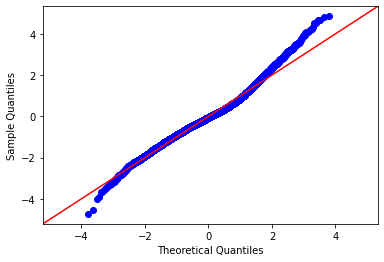

In [1461]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

Note: There appears to be some issues with the residuals not being normally distributed.

Errors appear to increase as the list_price decreases and increases. This doesn't bode well for our model. Subsetting the data to remove outliers and confining the model to this restricted domain may be necessary. A log transformation or something equivalent may also be appropriate.

## Check Homoscedasticity Assumption

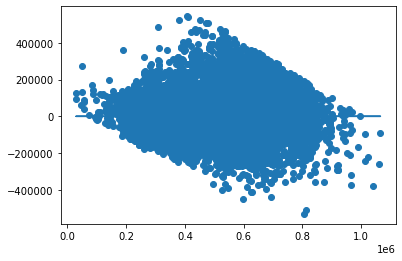

In [1462]:
plt.scatter(model.predict(train[x_cols]), model.resid)
plt.plot(model.predict(train[x_cols]), [0 for i in range(len(train))])

Note: There is no strong evidence of heteroscedasticity (unequal scatter of residuals).

## Evaluate Model using sci-kit learn's cross_val_score

In [1463]:
# Define X_train and y_train. As single feature need to reshape X_train into column vector
X_train = train[x_cols]
y_train = train['price']

# Create linear regression object
linreg = LinearRegression()

# Fit on training data
linreg.fit(X_train, y_train)

scores = cross_val_score(
            linreg, 
            X_train,
            y_train,
            cv=10,
            scoring="neg_mean_squared_error"
)

rmse_scores = np.sqrt(-scores)
display(rmse_scores)
display(rmse_scores.mean())
display(rmse_scores.std())

array([113315.12897953, 113423.04084876, 113808.41060962, 116032.37725662,
       112262.59402697, 111012.1411    , 110125.40780572, 111303.52247535,
       110410.69182614, 115497.90808449])

112719.12230132069

1947.2779725990974

# Model 2: Select Features

Note: Removed features based on linear analysis performed above
- yr_built features
- sqft_lot
- floors
- basement_1
- grade_3
- grade_4
- grade_12

In [1464]:
model_2_df = df[['price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'waterfront_1',
 'view_1',
 'condition_2',
 'condition_3',
 'condition_4',
 'condition_5',
 'renovated_1',
 'grade_11',
 'grade_5',
 'grade_6',
 'grade_7',
 'grade_8',
 'grade_9',
 'rank_10',
 'rank_2',
 'rank_3',
 'rank_4',
 'rank_5',
 'rank_6',
 'rank_7',
 'rank_8',
 'rank_9']]

In [1465]:
model_2_df.head()

,price,bedrooms,bathrooms,sqft_living,waterfront_1,view_1,condition_2,condition_3,condition_4,condition_5,...,grade_9,rank_10,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9
0,221900.0,3,1.00,1180,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,205425.0,2,1.00,880,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,445000.0,3,2.25,2100,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,236000.0,3,1.00,1300,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,170000.0,2,1.00,860,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [1466]:
# Defining the problem
outcome = 'price'
x_cols = list(model_2_df.columns)
x_cols.remove(outcome)

In [1467]:
print(len(train), len(test))
train.head()

14098 4700


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront_1,view_1,condition_2,condition_3,...,basement_1,rank_10,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9
4924,355000.0,3,0.75,1420,3060,1.0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
9193,320000.0,4,1.75,1820,7381,1.0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
8703,450000.0,3,1.00,1290,5440,1.0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
17157,250000.0,3,1.00,1100,7470,1.0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
14682,480000.0,4,2.75,2050,3960,1.0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0


In [1468]:
test.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront_1,view_1,condition_2,condition_3,...,basement_1,rank_10,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9
12532,565997.0,5,2.75,2730,5820,2.0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3774,470000.0,2,1.00,900,5512,1.0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
3492,645000.0,3,2.00,2130,4000,2.0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
10041,253200.0,3,1.00,1360,5840,1.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
10842,184900.0,3,1.00,1040,10080,1.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [1469]:
# Fitting the actual model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     2024.
Date:                Wed, 14 Apr 2021   Prob (F-statistic):               0.00
Time:                        00:40:14   Log-Likelihood:            -1.8070e+05
No. Observations:               14098   AIC:                         3.615e+05
Df Residuals:                   14072   BIC:                         3.617e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     4.592e+05   2.35e+04     19.531      0.000    4.13e+05    5.05e+05
bedrooms       799.5312   1171.696      0.682      0.495   -1497.149    3096.211
bathrooms    -2662.7118   1687.322     -1.578      0.115   -5970.087     644.664
sqft_living    100.2065      1.942     51.588      0.000      96.399     104.014
waterfront_1  1.833e+05   1.52e+04     12.036      0.000    1.53e+05    2.13e+05
view_1        8.264e+04   3081.662     26.817      0.000    7.66e+04    8.87e+04
condition_2   7.754e+04   2.39e+04      3.248      0.001    3.08e+04    1.24e+05
condition_3   1.064e+05   2.25e+04      4.738      0.000    6.24e+04     1.5e+05
condition_4   1.211e+05   2.25e+04      5.391      0.000    7.71e+04    1.65e+05
condition_5   1.626e+05   2.26e+04      7.203      0.000    1.18e+05    2.07e+05
renovated_1   5.143e+04   4483.061     11.471      0.000    4.26e+04    6.02e+04
grade_11      5.856e+04   1.56e+04      3.762      0.000    2.81e+04    8.91e+04
grade_5      -1.769e+05   8812.992    -20.075      0.000   -1.94e+05    -1.6e+05
grade_6      -1.446e+05   5963.551    -24.251      0.000   -1.56e+05   -1.33e+05
grade_7       -1.23e+05   5191.113    -23.703      0.000   -1.33e+05   -1.13e+05
grade_8       -9.23e+04   4944.027    -18.669      0.000   -1.02e+05   -8.26e+04
grade_9      -2.543e+04   5101.002     -4.985      0.000   -3.54e+04   -1.54e+04
rank_10      -3.665e+05   4184.165    -87.591      0.000   -3.75e+05   -3.58e+05
rank_2        -5.83e+04   4251.331    -13.712      0.000   -6.66e+04      -5e+04
rank_3         -1.1e+05   3773.638    -29.156      0.000   -1.17e+05   -1.03e+05
rank_4       -9.212e+04   3890.079    -23.680      0.000   -9.97e+04   -8.45e+04
rank_5       -1.895e+05   4285.137    -44.225      0.000   -1.98e+05   -1.81e+05
rank_6        -2.27e+05   3959.701    -57.327      0.000   -2.35e+05   -2.19e+05
rank_7       -2.393e+05   3868.118    -61.872      0.000   -2.47e+05   -2.32e+05
rank_8       -3.195e+05   3904.356    -81.841      0.000   -3.27e+05   -3.12e+05
rank_9       -3.659e+05   3960.058    -92.389      0.000   -3.74e+05   -3.58e+05
==============================================================================
Omnibus:                     1175.211   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2804.743
Skew:                           0.510   Prob(JB):                         0.00
Kurtosis:                       4.933   Cond. No.                     1.36e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.36e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Remove Uninfluential Features

In [1470]:
# Extract the p-value table from the summary and use it to subset our features
summary = model.summary()
p_table = summary.tables[1]
p_table = pd.DataFrame(p_table.data)
p_table.columns = p_table.iloc[0]
p_table = p_table.drop(0)
p_table = p_table.set_index(p_table.columns[0])
p_table['P>|t|'] = p_table['P>|t|'].astype(float)
x_cols = list(p_table[p_table['P>|t|'] < 0.05].index)
x_cols.remove('Intercept')
print(len(p_table), len(x_cols))
print(x_cols[:5])
p_table.head()

26 23
['sqft_living', 'waterfront_1', 'view_1', 'condition_2', 'condition_3']


,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
Intercept,4.592e+05,2.35e+04,19.531,0.000,4.13e+05,5.05e+05
bedrooms,799.5312,1171.696,0.682,0.495,-1497.149,3096.211
bathrooms,-2662.7118,1687.322,-1.578,0.115,-5970.087,644.664
sqft_living,100.2065,1.942,51.588,0.000,96.399,104.014
waterfront_1,1.833e+05,1.52e+04,12.036,0.000,1.53e+05,2.13e+05


In [1471]:
# Refit model with subset features
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     2200.
Date:                Wed, 14 Apr 2021   Prob (F-statistic):               0.00
Time:                        00:40:14   Log-Likelihood:            -1.8070e+05
No. Observations:               14098   AIC:                         3.615e+05
Df Residuals:                   14074   BIC:                         3.616e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     4.573e+05   2.34e+04     19.501      0.000    4.11e+05    5.03e+05
sqft_living     99.5230      1.478     67.356      0.000      96.627     102.419
waterfront_1  1.833e+05   1.52e+04     12.036      0.000    1.53e+05    2.13e+05
view_1        8.272e+04   3075.001     26.902      0.000    7.67e+04    8.88e+04
condition_2   7.793e+04   2.39e+04      3.265      0.001    3.11e+04    1.25e+05
condition_3   1.063e+05   2.25e+04      4.735      0.000    6.23e+04     1.5e+05
condition_4   1.215e+05   2.25e+04      5.408      0.000    7.75e+04    1.66e+05
condition_5   1.627e+05   2.26e+04      7.208      0.000    1.18e+05    2.07e+05
renovated_1   5.134e+04   4482.007     11.455      0.000    4.26e+04    6.01e+04
grade_11      5.884e+04   1.56e+04      3.780      0.000    2.83e+04    8.93e+04
grade_5      -1.754e+05   8759.009    -20.024      0.000   -1.93e+05   -1.58e+05
grade_6      -1.429e+05   5862.175    -24.385      0.000   -1.54e+05   -1.31e+05
grade_7      -1.221e+05   5113.650    -23.883      0.000   -1.32e+05   -1.12e+05
grade_8      -9.219e+04   4897.511    -18.824      0.000   -1.02e+05   -8.26e+04
grade_9      -2.536e+04   5086.492     -4.987      0.000   -3.53e+04   -1.54e+04
rank_10      -3.666e+05   4183.370    -87.626      0.000   -3.75e+05   -3.58e+05
rank_2       -5.845e+04   4249.756    -13.754      0.000   -6.68e+04   -5.01e+04
rank_3       -1.103e+05   3768.095    -29.279      0.000   -1.18e+05   -1.03e+05
rank_4       -9.233e+04   3887.705    -23.748      0.000   -9.99e+04   -8.47e+04
rank_5       -1.899e+05   4277.428    -44.389      0.000   -1.98e+05   -1.81e+05
rank_6       -2.272e+05   3958.060    -57.399      0.000   -2.35e+05   -2.19e+05
rank_7       -2.394e+05   3867.699    -61.903      0.000   -2.47e+05   -2.32e+05
rank_8       -3.199e+05   3898.277    -82.054      0.000   -3.28e+05   -3.12e+05
rank_9       -3.662e+05   3954.764    -92.589      0.000   -3.74e+05   -3.58e+05
==============================================================================
Omnibus:                     1186.080   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2832.040
Skew:                           0.514   Prob(JB):                         0.00
Kurtosis:                       4.940   Cond. No.                     1.36e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.36e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Evaluate Model using sci-kit learn's cross_val_score

In [1472]:
# Define X_train and y_train. As single feature need to reshape X_train into column vector
X_train = train[x_cols]
y_train = train['price']

# Create linear regression object
linreg = LinearRegression()

# Fit on training data
linreg.fit(X_train, y_train)

scores = cross_val_score(
            linreg, 
            X_train,
            y_train,
            cv=10,
            scoring="neg_mean_squared_error"
)

rmse_scores = np.sqrt(-scores)
display(rmse_scores)
display(rmse_scores.mean())
display(rmse_scores.std())

array([87786.00155687, 87752.10707989, 92557.12105089, 90272.84198046,
       88795.9761998 , 88452.09216538, 87136.9212588 , 91374.92794791,
       87051.18729272, 92964.25075798])

89414.34272906813

2110.7770078040535

# Check the Normality Assumption

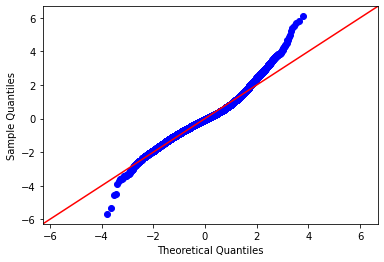

In [1473]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

## Check Homoscedasticity Assumption

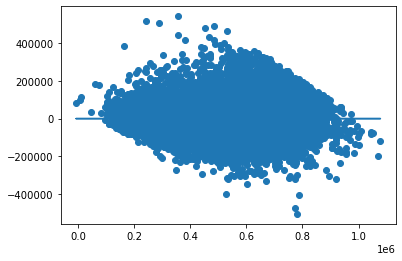

In [1474]:
plt.scatter(model.predict(train[x_cols]), model.resid)
plt.plot(model.predict(train[x_cols]), [0 for i in range(len(train))])

## Investigate Multicollinearity

In [1475]:
# Your code here
X = model_2_df[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

[('sqft_living', 15.225999138361658),
 ('waterfront_1', 1.0383326956255439),
 ('view_1', 1.1557631756630522),
 ('condition_2', 1.568710832967518),
 ('condition_3', 49.85167304627527),
 ('condition_4', 21.436520479721477),
 ('condition_5', 7.068329775990165),
 ('renovated_1', 1.0467447230860945),
 ('grade_11', 1.0834948783823304),
 ('grade_5', 1.5541577639458333),
 ('grade_6', 5.815071265826182),
 ('grade_7', 19.470498708285245),
 ('grade_8', 11.712284910838372),
 ('grade_9', 4.526132550690791),
 ('rank_10', 2.6214033897675986),
 ('rank_2', 2.2520374345744827),
 ('rank_3', 3.50030935655102),
 ('rank_4', 3.166803857096108),
 ('rank_5', 2.3129500608618163),
 ('rank_6', 2.995527607195496),
 ('rank_7', 3.451995076335091),
 ('rank_8', 3.275221507881275),
 ('rank_9', 2.9600913555957082)]

## Perform Another Round of Feature Selection

In [1476]:
vif_scores = list(zip(x_cols, vif))
x_cols = [x for x,vif in vif_scores if vif < 5]
print(len(vif_scores), len(x_cols))

23 16


In [1477]:
# Refit model with subset features
predictors = '+'.join(x_cols)
formula = outcome + "~" + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     1448.
Date:                Wed, 14 Apr 2021   Prob (F-statistic):               0.00
Time:                        00:40:15   Log-Likelihood:            -1.8460e+05
No. Observations:               14098   AIC:                         3.692e+05
Df Residuals:                   14081   BIC:                         3.694e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     6.727e+05   4199.515    160.186      0.000    6.64e+05    6.81e+05
waterfront_1  1.492e+05   2.01e+04      7.441      0.000     1.1e+05    1.89e+05
view_1        1.292e+05   4000.127     32.310      0.000    1.21e+05    1.37e+05
condition_2  -8.129e+04   1.11e+04     -7.351      0.000   -1.03e+05   -5.96e+04
renovated_1   5.016e+04   5880.843      8.530      0.000    3.86e+04    6.17e+04
grade_11      2.932e+05   1.97e+04     14.888      0.000    2.55e+05    3.32e+05
grade_5      -1.322e+05   8987.238    -14.705      0.000    -1.5e+05   -1.15e+05
grade_9       1.598e+05   3306.710     48.315      0.000    1.53e+05    1.66e+05
rank_10      -4.172e+05   5407.772    -77.148      0.000   -4.28e+05   -4.07e+05
rank_2       -6.633e+04   5573.916    -11.901      0.000   -7.73e+04   -5.54e+04
rank_3       -1.225e+05   4915.365    -24.916      0.000   -1.32e+05   -1.13e+05
rank_4       -1.389e+05   5073.135    -27.386      0.000   -1.49e+05   -1.29e+05
rank_5       -2.199e+05   5568.144    -39.485      0.000   -2.31e+05   -2.09e+05
rank_6       -2.544e+05   5129.647    -49.585      0.000   -2.64e+05   -2.44e+05
rank_7       -2.896e+05   4996.271    -57.963      0.000   -2.99e+05    -2.8e+05
rank_8       -3.594e+05   5037.785    -71.340      0.000   -3.69e+05    -3.5e+05
rank_9       -3.996e+05   5147.803    -77.628      0.000    -4.1e+05    -3.9e+05
==============================================================================
Omnibus:                      938.693   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1482.932
Skew:                           0.538   Prob(JB):                         0.00
Kurtosis:                       4.170   Cond. No.                         21.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1478]:
# Define X_train and y_train. As single feature need to reshape X_train into column vector
X_train = train[x_cols]
y_train = train['price']

# Create linear regression object
linreg = LinearRegression()

# Fit on training data
linreg.fit(X_train, y_train)

scores = cross_val_score(
            linreg, 
            X_train,
            y_train,
            cv=10,
            scoring="neg_mean_squared_error"
)

rmse_scores = np.sqrt(-scores)
display(rmse_scores)
display(rmse_scores.mean())
display(rmse_scores.std())

array([117693.00557977, 119402.97757226, 120018.52984231, 121973.86182799,
       115513.48346391, 114374.21947353, 115288.18731095, 116177.03888829,
       116094.80515523, 120696.36872833])

117723.24778425766

2491.3660952724613

In [1479]:
# Save model
#tuple_objects = (linreg, X_train, y_train)
#pickle.dump(tuple_objects, open('model_3.pkl','wb'))

# Predictions with test data

In [1480]:
test.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront_1,view_1,condition_2,condition_3,...,basement_1,rank_10,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9
12532,565997.0,5,2.75,2730,5820,2.0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3774,470000.0,2,1.00,900,5512,1.0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
3492,645000.0,3,2.00,2130,4000,2.0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
10041,253200.0,3,1.00,1360,5840,1.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
10842,184900.0,3,1.00,1040,10080,1.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [1481]:
len(test)

4700

In [1482]:
# Fitting the actual model
outcome = 'price'
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=test).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     467.4
Date:                Wed, 14 Apr 2021   Prob (F-statistic):               0.00
Time:                        00:40:16   Log-Likelihood:                -61602.
No. Observations:                4700   AIC:                         1.232e+05
Df Residuals:                    4683   BIC:                         1.233e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     6.537e+05   7860.044     83.165      0.000    6.38e+05    6.69e+05
waterfront_1  2.256e+05   6.96e+04      3.243      0.001    8.92e+04    3.62e+05
view_1        1.371e+05   7083.171     19.350      0.000    1.23e+05    1.51e+05
condition_2  -8.737e+04   2.09e+04     -4.181      0.000   -1.28e+05   -4.64e+04
renovated_1    5.57e+04   1.05e+04      5.310      0.000    3.51e+04    7.63e+04
grade_11      3.946e+05      4e+04      9.870      0.000    3.16e+05    4.73e+05
grade_5      -1.039e+05   1.78e+04     -5.833      0.000   -1.39e+05    -6.9e+04
grade_9       1.586e+05   5838.094     27.159      0.000    1.47e+05     1.7e+05
rank_10       -3.98e+05   9784.616    -40.673      0.000   -4.17e+05   -3.79e+05
rank_2       -5.224e+04   1.02e+04     -5.143      0.000   -7.22e+04   -3.23e+04
rank_3       -9.274e+04   9048.539    -10.249      0.000    -1.1e+05    -7.5e+04
rank_4        -1.22e+05   9180.241    -13.290      0.000    -1.4e+05   -1.04e+05
rank_5       -1.854e+05   1.02e+04    -18.224      0.000   -2.05e+05   -1.65e+05
rank_6       -2.347e+05   9481.314    -24.751      0.000   -2.53e+05   -2.16e+05
rank_7       -2.835e+05   9129.762    -31.050      0.000   -3.01e+05   -2.66e+05
rank_8        -3.38e+05   9241.740    -36.575      0.000   -3.56e+05    -3.2e+05
rank_9       -3.831e+05   9488.051    -40.375      0.000   -4.02e+05   -3.64e+05
==============================================================================
Omnibus:                      300.707   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              500.185
Skew:                           0.501   Prob(JB):                    2.43e-109
Kurtosis:                       4.245   Cond. No.                         42.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1483]:
len(x_cols)

16

## Interpret results

- Adj. R-squared:	0.800 = model adequately predicts sales price
- No p-values > 0.05 = features statistically significant

- bedrooms surprsingly had a negative impact on price
- having a waterfront had the highest impact on price
- sqft_living, view, rennovation had a postiive impact on price
- higher grades and conditions have positive impacts on price
- zip ranks negatively impacted price, but better rankings were less impactful

In [1484]:
# Define X_train and y_train. As single feature need to reshape X_train into column vector
X_test = test[x_cols]
y_test = test['price']

# Create linear regression object
linreg = LinearRegression()

# Fit on training data
linreg.fit(X_test, y_test)

scores = cross_val_score(
            linreg, 
            X_test,
            y_test,
            cv=10,
            scoring="neg_mean_squared_error"
)

rmse_scores = np.sqrt(-scores)
display(rmse_scores)
display(rmse_scores.mean())
display(rmse_scores.std())

array([115801.6460788 , 118754.29587485, 124519.49468691, 120551.11869743,
       118837.8333214 , 112143.59443134, 127247.62410757, 117127.49238825,
       122674.01645662, 118054.21873517])

119571.13347783436

4157.616832918159

Note: 
Train
- Mean: 0.445487007351384
- Std: 0.012876930669861342

Based on a rule of thumb, it can be said that RMSE values between 0.2 and 0.5 shows that the model can relatively predict the data accurately.

## Check the Normality Assumption

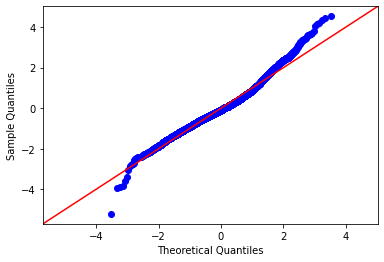

In [1485]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

## Check Homoscedasticity Assumption

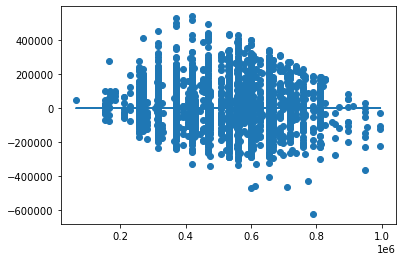

In [1486]:
plt.scatter(model.predict(test[x_cols]), model.resid)
plt.plot(model.predict(test[x_cols]), [0 for i in range(len(test))])